In [1]:
import numpy as np
import tensorflow as tf
from utility import *
import matplotlib.pyplot as plt
from matplotlib import colors
import os
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
X_orig, y_orig = loadData(halfSize=11, root="./", log_convert=True)
X_orig = np.array(X_orig).reshape(-1, 23, 23, 1)
y_orig = np.array(y_orig)
X_orig = (X_orig - X_orig.mean() )/ X_orig.std()

Starting to load data...
6053 6084
Finished loading data.


In [3]:
y_total = np.log(y_orig+1)
y_total = (y_total - y_total.mean()) / y_total.std()
totalSize = 10000
trainSize = 8000
X_total = X_orig[:totalSize]
y_total = y_total[:totalSize]
X_train = X_total[:trainSize]
y_train = y_total[:trainSize]
X_val = X_total[trainSize:]
y_val = y_total[trainSize:]
print(X_train.shape)
print(y_train.shape)
print(np.min(y_total))
print(np.max(y_total))

(8000, 23, 23, 1)
(8000,)
-1.34263164519
1.51351969033


In [8]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 23, 23, 1])
y = tf.placeholder(tf.float32, [None])
is_training = tf.placeholder(tf.bool)

def myModel(X, y):
    Wconv1 = tf.get_variable("Wconv1", shape=[3, 3, 1, 23])
    bconv1 = tf.get_variable("bconv1", shape=[23])
    Wconv2 = tf.get_variable("Wconv2", shape=[3, 3, 23, 23])
    bconv2 = tf.get_variable("bconv2", shape=[23])
    W1 = tf.get_variable("W1", shape=[8303, 10])
    b1 = tf.get_variable("b1", shape=[10])
    W2 = tf.get_variable("W2", shape=[10, 1])
    b2 = tf.get_variable("b2", shape=[1])
    
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 1, 1, 1], padding="VALID") + bconv1
    h1 = tf.nn.relu(a1)
    a2 = tf.nn.conv2d(h1, Wconv2, strides=[1, 1, 1, 1], padding="VALID") + bconv2
    h2 = tf.nn.relu(a2)
    h2_flat = tf.reshape(h2, [-1, 8303])
    h3 = tf.matmul(h2_flat, W1) + b1
    y_out = tf.matmul(h3, W2) + b2
    return y_out

y_out = myModel(X, y)

diff = y - y_out
mean_loss = tf.reduce_mean(tf.pow(y_out - y,2))

optimizer = tf.train.AdamOptimizer(5e-5)
train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 6.84
Epoch 1, Overall loss = 3.55


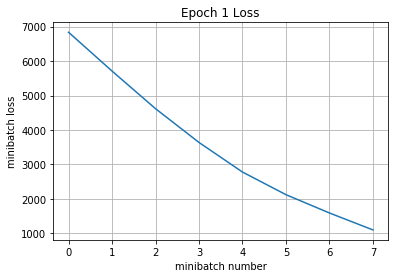

Epoch 2, Overall loss = 0.49


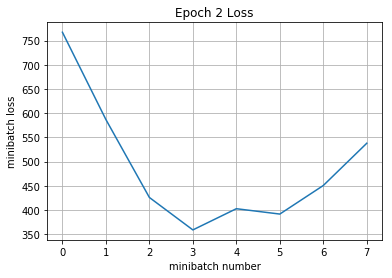

Epoch 3, Overall loss = 0.587


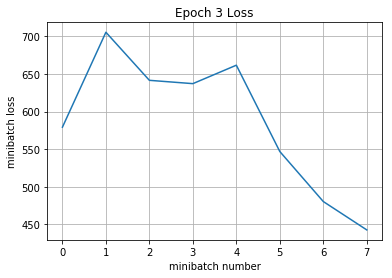

Epoch 4, Overall loss = 0.218


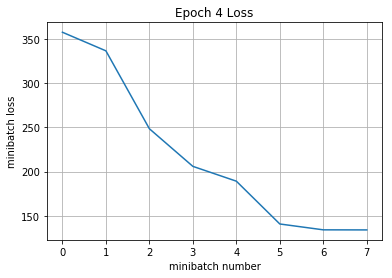

Epoch 5, Overall loss = 0.165


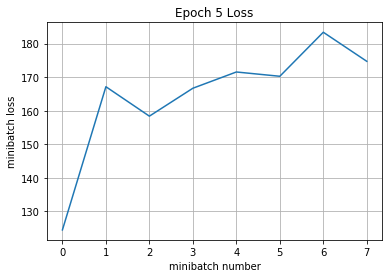

Epoch 6, Overall loss = 0.156


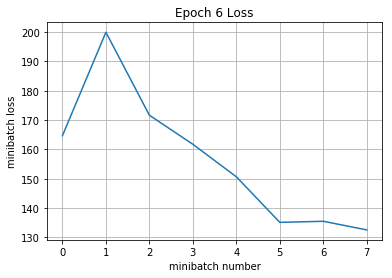

Epoch 7, Overall loss = 0.13


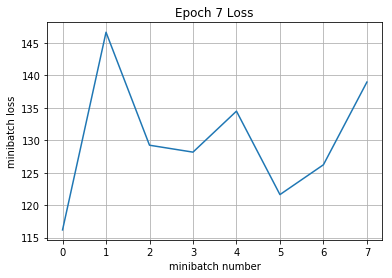

Epoch 8, Overall loss = 0.129


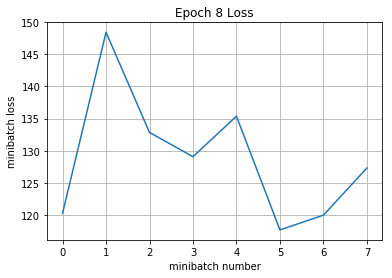

Epoch 9, Overall loss = 0.12


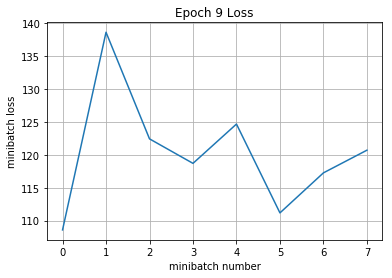

Epoch 10, Overall loss = 0.119


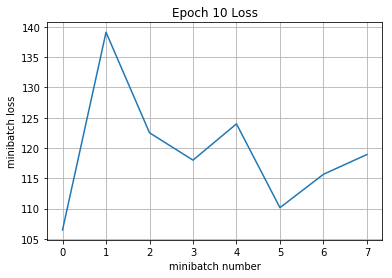

Validation
Epoch 1, Overall loss = 0.236


In [9]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=2, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, mean_loss]
    if training_now:
        variables[-1] = training
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g}"\
                      .format(iter_cnt,loss))
            iter_cnt += 1
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {1}, Overall loss = {0:.3g}"\
              .format(total_loss,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss

with tf.Session() as sess:
    with tf.device("/cpu:0"):
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,10,1000,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,1000)

In [19]:
a = tf.sparse_placeholder(tf.float64)
b = tf.placeholder(tf.float64)

ao = scipy.sparse.rand(3, 10000, density=.4)
tf_ao = tf.SparseTensorValue(
    indices=np.array([ao.row, ao.col]).T,
    values=ao.data,
    dense_shape=ao.shape)
bo = np.random.rand(10000, 5)

c = tf.sparse_tensor_dense_matmul(a, b)

feed_dict = {a: tf_ao, b: bo}

with tf.Session() as sess:
    with tf.device("/gpu:0"):
        out = sess.run(c, feed_dict=feed_dict)
        print(out)
        print("\n")
        print(ao.dot(bo))

[[ 1002.98787103  1005.98221935  1018.71952568  1013.87421846
   1015.10508783]
 [  955.26880411   959.66873283   961.76369047   985.98702425
    976.09324116]
 [  988.86471312   981.36787995  1006.06368203  1009.47128104
   1001.83746088]]


[[ 1002.98787103  1005.98221935  1018.71952568  1013.87421846
   1015.10508783]
 [  955.26880411   959.66873283   961.76369047   985.98702425
    976.09324116]
 [  988.86471312   981.36787995  1006.06368203  1009.47128104
   1001.83746088]]
